In [8]:
import os, sys
import pickle
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch import autograd
from torch.optim import SGD, Adam, rmsprop
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
sys.path.append('../')

from src.loss import distance_matrix, get_hardest_points, topk_hardest_mean, batch_hard_loss
from src.dataset import TripletDataset
from src.utils import get_user_dict
from src.models import LinearModel

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

----------------

In [4]:
to_img = torchvision.transforms.ToPILImage()

In [5]:
def batch_to_img(batch, use_cuda=False):
    if use_cuda:
        batch = batch.cpu()
    
    n_imgs = batch.shape[0]
    batch = batch.reshape(n_imgs, 1, batch.shape[1], batch.shape[2])
    
    return to_img(torchvision.utils.make_grid(batch, nrow = int(np.sqrt(n_imgs))))

In [6]:
def distance_matrix_plot(D, filename = None):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(D.detach().numpy())

    for i in range(N):
        plt.axvline(x=M*(i+1)-.5, color='white')
        plt.axhline(y=M*(i+1)-.5, color='white')
    
    if not filename is None:
        fig.savefig(filename)
        plt.close()


--------

In [7]:
class LSTM(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim, sentence_size, minibatch_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.sentence_size = sentence_size
        self.minibatch_size = minibatch_size

        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)  # <- change here

        self.hidden2tag = torch.nn.Linear(2*self.hidden_dim*self.sentence_size, 512)
        self.lin = torch.nn.Linear(512, 300)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        self.a = autograd.Variable(torch.zeros(2, self.minibatch_size, self.hidden_dim))
        self.b = autograd.Variable(torch.zeros(2, self.minibatch_size, self.hidden_dim))
        
        return self.a, self.b

    def forward(self, sentence):
        embeds = sentence.transpose(2,0).transpose(2,1)
        lstm_out, self.hidden = self.lstm(
            embeds, self.hidden)
        x = (lstm_out.transpose(0,1)).contiguous().view(self.minibatch_size, -1)
        
        tag_space = F.relu(self.hidden2tag(x))
        tag_space = self.lin(tag_space)
        
        return tag_space

## Dataset

In [60]:
with open('../dados/voxforge_data_dict_user.pk', 'rb') as fp:
    data = pickle.load(fp)

In [61]:
users = list(data.keys())

In [62]:
len(users)

187

In [63]:
train_users = users[0:150]
test_users = users[150:]

In [64]:
len(train_users), len(test_users)

(150, 37)

In [65]:
data[users[0]][0].shape

torch.Size([10, 20, 431])

### Treinamento

In [66]:
N = 10
M = 5
KP = 1
KN = 1
max_iter = 700

In [67]:
lstm = LSTM(20, 32, 431, M*N)

In [68]:
optimizer = Adam(lstm.parameters())
#optimizer = rmsprop.RMSprop(cnn.parameters())
#optimizer = SGD(cnn.parameters(), lr=1e-3)

In [69]:
ppath = './Distance_matrix/N=%d, M=%d, KP=%d, KN=%d, %d' % (N, M, KP, KN, max_iter)
if not os.path.exists(ppath):
    os.mkdir(ppath)
print(ppath)

./Distance_matrix/N=10, M=5, KP=1, KN=1, 700


In [70]:
data['1snoke'][0].shape

torch.Size([10, 20, 431])

In [77]:
n_iter = 0
loss_list = []

while True:
    n_iter += 1
    
    # Monta um batch aleatóriamente
    batch = []
    for u in np.random.choice(train_users, N, replace=False):
        n_samples = data[u][0].shape[0]
        selected_samples = np.random.choice(np.arange(n_samples), M, replace=False)
        
        batch.append(data[u][0][selected_samples])
        
    batch = torch.cat(batch)
    
    lstm.hidden = lstm.init_hidden()
    lstm.zero_grad()
    optimizer.zero_grad()
    embeddings = lstm.forward(batch)
    
    #lstm.hidden[0].detach_()
    #lstm.hidden[1].detach_()
    
    D = distance_matrix(embeddings)
    hardest_positives, hardest_negatives = topk_hardest_mean(D, M, N, KP, KN, use_cuda=False)
    loss = batch_hard_loss(hardest_positives, hardest_negatives, 1)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.detach().cpu().numpy())
    print('(%d/%d) Loss: %f, H.pos - H.neg: %f' % (n_iter, max_iter, loss.item(), (max(hardest_positives) - min(hardest_positives))))
    
    if (n_iter % 10) == 0:
        distance_matrix_plot(D.cpu(), os.path.join(ppath, 'iter_%03d.jpg' % n_iter))
    
    if n_iter == max_iter:
        break

import pandas as pd        
loss_list = np.array(loss_list)
loss_list = pd.Series(loss_list)

fig = plt.figure(figsize=(8,6))
loss_list.rolling(10).mean().plot()
fig.savefig(os.path.join(ppath, 'loss.png'))
plt.close()

(1/700) Loss: 1.086966, H.pos - H.neg: 0.249327
(2/700) Loss: 20.907864, H.pos - H.neg: 97.760284
(3/700) Loss: 9.051293, H.pos - H.neg: 34.336361
(4/700) Loss: 4.973498, H.pos - H.neg: 14.136475
(5/700) Loss: 2.300590, H.pos - H.neg: 10.648529
(6/700) Loss: 3.385249, H.pos - H.neg: 26.592133
(7/700) Loss: 4.487453, H.pos - H.neg: 19.096840
(8/700) Loss: 3.768819, H.pos - H.neg: 37.643593
(9/700) Loss: 3.117078, H.pos - H.neg: 16.616631
(10/700) Loss: 8.629251, H.pos - H.neg: 82.641151
(11/700) Loss: 4.556280, H.pos - H.neg: 54.140858
(12/700) Loss: 2.392731, H.pos - H.neg: 25.305527
(13/700) Loss: 8.416869, H.pos - H.neg: 121.625572
(14/700) Loss: 3.963571, H.pos - H.neg: 41.445671
(15/700) Loss: 1.827857, H.pos - H.neg: 27.869659
(16/700) Loss: 2.930750, H.pos - H.neg: 24.067459
(17/700) Loss: 2.826052, H.pos - H.neg: 13.360039
(18/700) Loss: 2.778297, H.pos - H.neg: 17.079483
(19/700) Loss: 7.194631, H.pos - H.neg: 117.012222
(20/700) Loss: 2.070452, H.pos - H.neg: 32.773254
(21/700

/home/pi/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## KNN no espaço dos Embeddings gerados (conj. teste)

In [78]:
from sklearn.neighbors import KDTree
from sklearn.manifold import TSNE
from plotnine import *

In [79]:
y = []
e = []
with torch.no_grad():
    for u in test_users:
        print('%s' % u, end=', ')
        lstm.minibatch_size = data[u][0].shape[0]
        lstm.hidden = lstm.init_hidden()

        y.append([u]*data[u][0].shape[0])
        e.append(lstm(data[u][0]).detach().numpy())

e, y = np.concatenate(e), np.concatenate(y)

anap40, anoldman, anonymous, apdsqueaky, ariyan, arjuan, asladic, asp, atterer, avsa242, ax, azmisov, bachroxx, bebe, beez1717, bendauphinee, bhart, bigmbywater, bjb, blood, bloomtom, bluepeppers, bonzer, brad, bread555, bugsysservant, cactusbin, camdixon, catchercradle, ccrawford, cebidae, chandrashekhar, chocoholic, chris21, chrisspen, cj5, cmu_us_bdl_arctic, 

In [80]:
tree = KDTree(e, metric = 'euclidean')
acertos = 0

for i in range(e.shape[0]):
    dist, ind = tree.query(e[i:i+1], k=5)
    ind = np.array(y[ind[0]])
    
    if (ind == y[i:i+1]).sum() >= 3:
        acertos += 1    

In [81]:
acertos/e.shape[0]*100

98.88947646747752

### T-SNE (conj. teste)

In [82]:
tsne = TSNE()
x_t = tsne.fit_transform(e)

In [83]:
df = pd.DataFrame({'Usuário': y.astype('str'), 'Dimensão 1': x_t[:,0], 'Dimensão 2': x_t[:,1]})

In [84]:
df.to_csv('./tsne_test.csv', sep = ';', index=False)

In [85]:
mean_df = pd.DataFrame(df.groupby('Usuário')[['Dimensão 1', 'Dimensão 2']].mean()).reset_index()

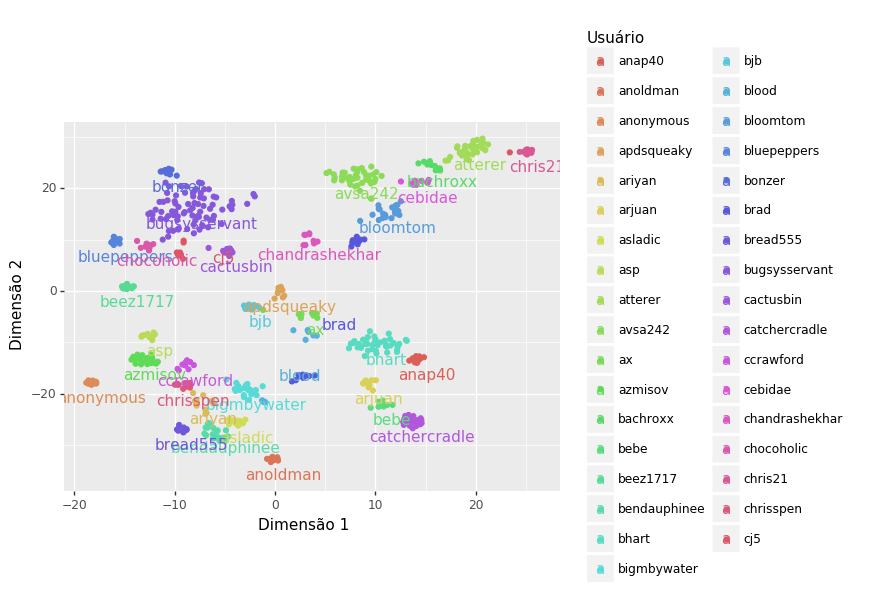

<ggplot: (-9223363282699482869)>

In [484]:
ggplot(df, aes('Dimensão 1', 'Dimensão 2', color='Usuário', label = 'Usuário')) + geom_point() +\
geom_text(data = mean_df, nudge_y = -3, nudge_x = 1)

------------